## Semi-supervised pattern recognition

Let us now explore two, more elaborate, classification tasks, which showcase the
benefit of using logical reasoning alongside machine learning.

The tasks consist in predicting the sum of two numbers given in input. We have the images for these numbers but we do not
know their classes, namely their labels. The only thing we know is their sum. In particular, the first task is simpler
and consists in predicting the sum of two single-digit numbers. The second one is more complicated since it consists in
predicting the sum of two multi-digits numbers.

To create our dataset, we use the popular MNIST dataset, which contains labelled manuscripted digits.

**Single digits addition:**
consider the predicate $addition(X, Y, n)$, where $X$ and $Y$ are
images of digits, and $n$ is a natural number corresponding to the sum of these digits. This predicate should return an
estimate of the validity of the addition. For instance, $addition(img(8), img(3), 11)$ is a
valid addition, while $addition(img(3), img(3), 5)$ is not. In this example, $img(x)$ means "an image of a $x$", where $x$ is
a digit label. It has not to be confused with a logical function.

**Multi digits addition:**
the experiment is extended to numbers with more than one
digit. Consider the predicate $addition([img(X_1), img(X_2)],[img(Y_1), img(Y_2)], n)$, where $[img(X_1), img(X_2)]$ and
$[img(Y_1), img(Y_2)]$ are lists of images of digits, representing two multi-digit numbers, and $n$ is a natural
number corresponding to the sum of the two multi-digit numbers. For instance,
$addition([img(2), img(0)], [img(1), (7)], 37)$ is a valid addition, while $addition([img(5), img(4)], [img(9), img(0)], 50)$
is not.

A natural Neural-Symbolic approach is to seek to learn a single digit classifier and benefit from knowledge readily available about the properties of the addition in this case.For instance, suppose that a predicate $digit(x,d)$ gives the likelihood of an image $x$ being of digit $d$. A definition for $addition(img(3), img(8), 11)$ in LTN is:

$\exists d_1, d_2 : d_1 + d_2 = 11 \text{ } (digit(img(3), d_1) \land digit(img(8), d_2))$.

The above task is made more complicated by not providing labels for the
single digit images during training. Instead, training takes place on pairs of images
with labels made available for the result only, that is, the sum of the individual
labels. The single digit classifier is not explicitly trained by itself. Its output is a
latent information which is used by the logic. However, this does not pose a problem
for end-to-end Neural-Symbolic systems such as LTN, for which the
gradients can propagate through the logical structures.

We start by illustrating an LTN theory that can be used to learn the predicate
$digit$. The specification of the theory below is for the single digit addition example,
although it can be extended easily to the multiple digits case:

**Domains:**
- $images$, denoting the MNIST digit images;
- $results$, denoting the integers which are the labels for the results of the additions;
- $digits$, denoting the digits from 0 to 9.

**Variables:**
- $x, y$ ranging over the MNIST images;
- $n$ for the labels, i.e., the results of the additions;
- $d_1, d_2$ ranging over digits;
- $D(x) = D(y) = images$;
- $D(n) = results$;
- $D(d_1) = d(d_2) = digits$.

**Predicates:**
- $digit(x, d)$ for the single digit classifier, where $d$ is a term denoting a digit
constant or a digit variable. The classifier should return the probability of an
image $x$ being of digit $d$;
- $D_{in}(digit) = images,digits$.

**Axioms:**

Single digit addition:

$\forall Diag(x, y, n) \text{ } (\exists d_1, d_2 : d_1 + d_2 = n \text{ } (digit(x, d_1) \land digit(y, d_2)))$

Multiple digit addition:

$\forall Diag(x_1, x_2, y_1, y_2, n) \text{ } (\exists d_1, d_2, d_3, d_4: 10d_1 + d_2 + 10d_3 + d_4 = n \text{ } (digit(x_1, d_1) \land digit(x_2, d_2) \land digit(y_1, d_3) \land digit(y_2, d_4)))$

Notice the use of $Diag$: when grounding $x,y,n$ with three sequences of values,
the *i-th* examples of each variable are matching. That is, $(\mathcal{G}(x)_i, \mathcal{G}(y)_i, \mathcal{G}(n)_i)$ is
a tuple from our dataset of valid additions. Using the diagonal quantification,
LTN aggregates pairs of images and their corresponding result, rather than any
combination of images and results.

Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training)
that could add up to the result label
(given during training), we incorporate symbolic information into the system.


**Grounding:**
- $\mathcal{G}(images)=[0, 1]^{28 \times 28 \times 1}$. The MNIST dataset has images of 28 by 28 pixels.
The images are grayscale and have just one channel. The RGB pixel values from
0 to 255 of the MNIST dataset are scaled to the range [0, 1];
- $\mathcal{G}(results)=\mathbb{N}$;
- $\mathcal{G}(digits) = {0, 1, \dots, 9}$;
- $\mathcal{G}(x) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(y) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(n) \in \mathbb{N}^{m}$.
Notice the use of the same number $m$ of examples for each of these variables as they are supposed
to match one-to-one due to the use of $Diag$;
- $\mathcal{G}\left(d_{1}\right)=\mathcal{G}\left(d_{2}\right)=\langle 0,1, \ldots, 9\rangle$;
- $\mathcal{G}(digit \mid \theta): x, d \rightarrow \operatorname{onehot}(d)^{\top} \cdot \operatorname{softmax}\left(\operatorname{CNN}_{\theta}(x)\right)$, where $CNN$
is a Convolutional Neural Network with 10 output neurons for each class. Notice that, in contrast
with the previous examples, $d$ is an integer label; $onehot(d)$ converts it into a
one-hot label.


### Dataset

Now, let's import and create the dataset.

The MNIST dataset contains 70000 images, subdivided into 60000 examples for training and 10000 for test. For our task,
we need to create an ad-hoc dataset starting from the MNIST dataset.

For the single digit case, the first 30000 images of the training set are used as left operands for the addition, while
the last 30000 images are used as right operands. The sum of the labels of the left and right operands is used as target.
The same process is repeated to create the test set.

For the multiple digit case, the training set is divided into four groups of 15000 images. The first two groups form the
left operands for the additions, while the last two groups the right operands. The target is created in a similar manner
to the previous case.


## 半监督模式识别

让我们现在探索两个更复杂的分类任务，以展示将逻辑推理与机器学习相结合的好处。

任务是预测给定输入的两个数字的和。我们有这些数字的图像，但不知道它们的类别，即标签。我们唯一知道的是它们的和。特别是，第一个任务较简单，包含预测两个个位数的和。第二个任务更复杂，因为它涉及预测两个多位数的和。

为了创建我们的数据集，我们使用了流行的MNIST数据集，其中包含标记的手写数字。

**个位数相加：**
考虑谓词 $addition(X, Y, n)$，其中 $X$ 和 $Y$ 是数字的图像，$n$ 是对应这些数字和的自然数。这个谓词应该返回对加法有效性的估计。例如，$addition(img(8), img(3), 11)$ 是一个有效的加法，而 $addition(img(3), img(3), 5)$ 则不是。在这个例子中，$img(x)$ 意味着“$x$ 的图像”，其中 $x$ 是一个数字标签（digit label）。这与逻辑函数（a logical function）不同。

**多位数相加：**
实验扩展到多位数。考虑谓词 $addition([img(X_1), img(X_2)],[img(Y_1), img(Y_2)], n)$，其中 $[img(X_1), img(X_2)]$ 和 $[img(Y_1), img(Y_2)]$ 是数字图像列表，代表两个多位数，$n$ 是这两个多位数和的自然数。例如，$addition([img(2), img(0)], [img(1), (7)], 37)$ 是一个有效的加法，而 $addition([img(5), img(4)], [img(9), img(0)], 50)$ 则不是。

一种自然的神经符号方法是尝试学习一个个位数分类器，并利用关于加法性质的现有知识。例如，假设谓词 $digit(x,d)$ 给出了图像 $x$ 是数字 $d$ 的可能性。在 LTN 中 $addition(img(3), img(8), 11)$ 的定义为（addition这个谓词是理论上的，在具体的代码实现中，没有这个谓词，这个谓词定义为下面的式子）：（这里的d1+d2=11，是条件量化，计算存在的时候，只计算d1和d2相加为11的那些d1和d2。你从头分析，会发现这里是一个二维矩阵，d1和d2分别是两个轴）

$$
\exists d_1, d_2 : d_1 + d_2 = 11 \text{ } (digit(img(3), d_1) \land digit(img(8), d_2))
$$

通过不提供训练期间的单个数字图像标签，上述任务变得更加复杂。相反，训练在一对图像上进行，只提供结果的标签，即个体标签的和。单个数字分类器不会单独显式训练。它的输出是逻辑使用的潜在信息。然而，这对像 LTN 这样的端到端神经符号系统并不构成问题，因为梯度可以通过逻辑结构传播。

我们首先说明一个可以用于学习谓词 $digit$ 的 LTN 理论。下面的理论规格是针对单个数字加法示例的，但可以轻松扩展到多位数情况：

**领域：**
- $images$，表示 MNIST 数字图像；
- $results$，表示加法结果的整数标签；
- $digits$，表示 0 到 9 的数字。

**变量：**
- $x, y$ 取值于 MNIST 图像；
- $n$ 表示标签，即加法结果；
- $d_1, d_2$ 取值于数字；
- $D(x) = D(y) = images$；
- $D(n) = results$；
- $D(d_1) = D(d_2) = digits$。

**谓词：**
- $digit(x, d)$ 用于单个数字分类器，其中 $d$ 是表示数字常量或数字变量的项。分类器应返回图像 $x$ 是数字 $d$ 的概率；
- $D_{in}(digit) = images,digits$。这里的这个digit指的是前面的那个谓词digit

**公理：**

单个数字加法：

$$
\forall Diag(x, y, n) \text{ } (\exists d_1, d_2 : d_1 + d_2 = n \text{ } (digit(x, d_1) \land digit(y, d_2)))
$$

多位数加法：

$$
\forall Diag(x_1, x_2, y_1, y_2, n) \text{ } (\exists d_1, d_2, d_3, d_4: 10d_1 + d_2 + 10d_3 + d_4 = n \text{ } (digit(x_1, d_1) \land digit(x_2, d_2) \land digit(y_1, d_3) \land digit(y_2, d_4)))
$$

注意使用 $Diag$：当用三个值序列对 $x,y,n$ 进行基础化时，每个变量的第 *i* 个示例是匹配的。即 $(\mathcal{G}(x)_i, \mathcal{G}(y)_i, \mathcal{G}(n)_i)$ 是我们有效加法数据集中的一个元组。使用对角量化，LTN 聚合成对图像及其对应的结果，而不是任意组合的图像和结果。

还请注意守卫量化：仅对可能加起来等于结果标签（训练期间未提供）的中间标签进行量化，我们将符号信息引入系统。

**基础化：**
- $\mathcal{G}(images)=[0, 1]^{28 \times 28 \times 1}$。MNIST 数据集的图像为 28 x 28 像素。图像是灰度的，只有一个通道。MNIST 数据集的 RGB 像素值从 0 到 255 缩放到 [0, 1] 范围；
- $\mathcal{G}(results)=\mathbb{N}$；
- $\mathcal{G}(digits) = {0, 1, \dots, 9}$；
- $\mathcal{G}(x) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(y) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(n) \in \mathbb{N}^{m}$。注意对每个变量使用相同数量的示例 $m$，因为它们应该由于使用 $Diag$ 而一一匹配；
- $\mathcal{G}\left(d_{1}\right)=\mathcal{G}\left(d_{2}\right)=\langle 0,1, \ldots, 9\rangle$；
- $\mathcal{G}(digit \mid \theta): x, d \rightarrow \operatorname{onehot}(d)^{\top} \cdot \operatorname{softmax}\left(\operatorname{CNN}_{\theta}(x)\right)$，其中 $CNN$ 是一个具有每类 10 个输出神经元的卷积神经网络。注意，与前面的示例不同，$d$ 是一个整数标签；$onehot(d)$ 将其转换为一个独热标签。

### 数据集

现在，让我们导入并创建数据集。

MNIST 数据集包含 70000 张图像，分为 60000 个训练示例和 10000 个测试示例。对于我们的任务，我们需要从 MNIST 数据集创建一个特定的数据集。

对于个位数情况，训练集的前 30000 张图像用作加法的左操作数，最后 30000 张图像用作右操作数。左操作数和右操作数标签的和用作目标。相同的过程用于创建测试集。

对于多位数情况，训练集分为四组，每组 15000 张图像。前两组形成加法的左操作数，而后两组形成右操作数。目标的创建方式与前一种情况类似。

In [1]:
import torch
import pandas as pd
import torchvision

def get_mnist_dataset_for_digits_addition(single_digit=True):
    """
    It prepares the dataset for the MNIST single digit or multi digits addition example of the LTN paper.

    :param single_digit: whether the dataset has to be generated for the single digit or multi digits example (please,carefully read the examples in the paper to understand the differences between the two).
    :return: a tuple of two elements. The first element is the training set, while the second element is the test set.
    Both training set and test set are lists that contain the following information:
        1. a list [left_operands, right_operands], where left_operands is a list of MNIST images that are used as the
        left operand of the addition, while right_operands is a list of MNIST images that are used as the right operand
        of the addition;
        2. a list containing the summation of the labels of the images contained in the list at point 1. The label of
        the left operand is added to the label of the right operand, and the target label is generated. This represents
        the target of the digits addition task.
    Note that this is the output of the process for the single digit case. In the multi digits case the list at point
    1 will have 4 elements since in the multi digits case four digits are involved in each addition (two digits
    represent the first operand and two digits the second operand).
    
    它为 LTN 论文中的 MNIST 单个数字或多个数字加法示例准备数据集。
    
    :param single_digit: 数据集是否需要为单个数字或多个数字示例生成（请仔细阅读论文中的示例以了解两者之间的区别）。 # todo:详细阅读
    :return: 一个包含两个元素的元组。第一个元素是训练集，第二个元素是测试集。训练集和测试集都是包含以下信息的列表：（意思应该是元组中包含两个列表。每个列表又包含两个列表）
    1. 一个列表 [left_operands, right_operands]，其中 left_operands 是用于加法左操作数的 MNIST 图像列表，而 right_operands 是用于加法右操作数的 MNIST 图像列表；
    2. 一个包含第 1 点中列表中图像标签和的列表。左操作数的标签与右操作数的标签相加，生成目标标签。这代表数字加法任务的目标。
    请注意，这是单个数字情况的输出。在多个数字情况下，第 1 点中的列表将有 4 个元素，因为在多个数字情况下，每个加法涉及四个数字（两个数字代表第一个操作数，两个数字代表第二个操作数）。
    """
    if single_digit:
        n_train_examples = 30000
        n_test_examples = 5000
        n_operands = 2 # 设置操作数的数量，单个数字是2个操作数，多个数字是4个操作数。
    else:
        n_train_examples = 15000
        n_test_examples = 2500
        n_operands = 4

    mnist_train = torchvision.datasets.MNIST("./datasets/", train=True, download=True,transform=torchvision.transforms.ToTensor()) # 返回值类型是torchvision.datasets.mnist.MNIST # 
    mnist_test = torchvision.datasets.MNIST("./datasets/", train=False, download=True,transform=torchvision.transforms.ToTensor())

    train_imgs, train_labels, test_imgs, test_labels = mnist_train.data, mnist_train.targets, mnist_test.data, mnist_test.targets

    train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0

    train_imgs, test_imgs = torch.unsqueeze(train_imgs, 1), torch.unsqueeze(test_imgs, 1)

    imgs_operand_train = [train_imgs[i * n_train_examples:i * n_train_examples + n_train_examples] for i in range(n_operands)]
    labels_operand_train = [train_labels[i * n_train_examples:i * n_train_examples + n_train_examples] for i in range(n_operands)]

    imgs_operand_test = [test_imgs[i * n_test_examples:i * n_test_examples + n_test_examples] for i in range(n_operands)]
    labels_operand_test = [test_labels[i * n_test_examples:i * n_test_examples + n_test_examples] for i in range(n_operands)]

    if single_digit:
        label_addition_train = labels_operand_train[0] + labels_operand_train[1]
        label_addition_test = labels_operand_test[0] + labels_operand_test[1]
    else:
        label_addition_train = 10 * labels_operand_train[0] + labels_operand_train[1] + 10 * labels_operand_train[2] + labels_operand_train[3]

        label_addition_test = 10 * labels_operand_test[0] + labels_operand_test[1] + 10 * labels_operand_test[2] + labels_operand_test[3]

    train_set = [torch.stack(imgs_operand_train, dim=1), label_addition_train]
    test_set = [torch.stack(imgs_operand_test, dim=1), label_addition_test]

    return train_set, test_set

# single digit dataset # 单个数字数据集
single_d_train_set, single_d_test_set = get_mnist_dataset_for_digits_addition(single_digit=True)
# multi digit dataset # 多个数字数据集
multi_d_train_set, multi_d_test_set = get_mnist_dataset_for_digits_addition(single_digit=False)

C:\Users\mircocrift\AppData\Local\Temp\ipykernel_25924\1318613235.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Just for illustration, we show the first example of the training set for the single digit case. This should help in
understanding how the dataset is created.

仅供说明，我们展示了单个数字案例训练集的第一个示例。这应该有助于理解数据集是如何创建的。

Operands are displayed in the following images:


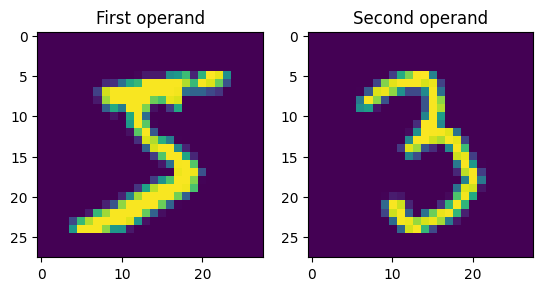

The target label (sum) for these operands is: 8


In [2]:
import matplotlib.pyplot as plt
first_example_images = single_d_train_set[0][0]
first_example_label = single_d_train_set[1][0]

print("Operands are displayed in the following images:")
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(first_example_images[0].permute(1, 2, 0))
ax.set_title('First operand')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(first_example_images[1].permute(1, 2, 0))
ax.set_title('Second operand')
plt.show()
print("The target label (sum) for these operands is: %d" % first_example_label.item())


### LTN setting

In order to define our knowledge base (axioms), we need to define predicate $digit$, variables $d_1$, $d_2$, $d_3$, $d_4$,
connectives, universal and existential quantifiers, and the `SatAgg` operator.

For connectives and quantifiers, we use the stable product configuration (seen in the tutorials).

For predicate $digit$, we have two models. The first one implements a $CNN$ which outputs the logits for the ten classes of
the MNIST dataset, given an image $x$ in input. The second model takes as input a labelled example $(x,d)$, it computes the logits
using the first model and then returns the prediction (*softmax*) for class $d$. In other words, it computes the likelihood
of image $d$ being of digit $d$.

We need two separated models because we need both logits and probabilities. Logits are used to compute the classification
accuracy, while probabilities are interpreted as truth values to compute the satisfaction level of the knowledge base.

The variables $d_1$, $d_2$, $d_3$, and $d_4$ represent the 10 digit labels of the MNIST dataset, namely they are the sequence $\langle 0,1, \ldots, 9\rangle$.

`SatAgg` is defined using the `pMeanError` aggregator.

### LTN 设置

为了定义我们的知识库（公理），我们需要定义谓词 $digit$，变量 $d_1$，$d_2$，$d_3$，$d_4$，连接词，全称和存在量词，以及 `SatAgg` 操作符。

对于连接词和量词，我们使用稳定乘积配置（在教程中已见过）。

对于谓词 $digit$，我们有两个模型。第一个模型实现了一个 $CNN$，它根据输入图像 $x$ 输出 MNIST 数据集的十个类别的 logits。第二个模型以一个标记示例 $(x,d)$ 作为输入，使用第一个模型计算 logits，然后返回类别 $d$ 的预测值（*softmax*）。换句话说，它计算图像 $d$ 是数字 $d$ 的可能性。

我们需要两个独立的模型，因为我们既需要 logits 也需要概率。logits 用于计算分类准确性，而概率被解释为真值，用于计算知识库的满足度。

变量 $d_1$，$d_2$，$d_3$ 和 $d_4$ 表示 MNIST 数据集的 10 个数字标签，即它们是序列 $\langle 0,1, \ldots, 9\rangle$。

`SatAgg` 使用 `pMeanError` 聚合器定义。

In [3]:
from torch.nn.init import xavier_uniform_, normal_, kaiming_uniform_
import ltn

# we define the variables # 定义变量
d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
d_2 = ltn.Variable("d_2", torch.tensor(range(10)))
# these are used only in the multi digit case # 这些仅在多个数字的情况下使用
d_3 = ltn.Variable("d_3", torch.tensor(range(10)))
d_4 = ltn.Variable("d_4", torch.tensor(range(10)))

# we define predicate digit # 我们定义谓词digit
class MNISTConv(torch.nn.Module):
    """
    CNN that returns linear embeddings for MNIST images. It is used in the single digit and multi digits addition
    examples of the LTN paper.
    Args:
        conv_channels_sizes: tuple containing the number of channels of the convolutional layers of the model. The first
        element of the tuple must be the number of input channels of the first conv layer, while the last element
        of the tuple must be the number of output channels of the last conv layer. Specifically, the number of conv
        layers constructed is equal to `len(conv_channels_sizes) - 1`;
        kernel_sizes: tuple containing the sizes of the kernels used in the conv layers of the architecture;
        linear_layers_sizes: tuple containing the sizes of the linear layers used as the final layers of the
        architecture. The first element of the tuple must be the number of features in input to the first linear layer,
        while the last element of the tuple must be the number of output features of the last linear layer. Specifically,
        the number of layers constructed is equal to `len(linear_layers_sizes) - 1`.
    用于 MNIST 图像的返回线性嵌入的 CNN。在 LTN 论文的单个数字和多个数字加法示例中使用。
    
    参数：
    - `conv_channels_sizes`：包含模型卷积层通道数的元组。元组的第一个元素必须是第一个卷积层的输入通道数，而最后一个元素必须是最后一个卷积层的输出通道数。具体来说，卷积层的数量等于 `len(conv_channels_sizes) - 1`。
    - `kernel_sizes`：包含架构中卷积层使用的核大小的元组。
    - `linear_layers_sizes`：包含作为架构最终层使用的线性层大小的元组。元组的第一个元素必须是第一个线性层的输入特征数，而最后一个元素必须是最后一个线性层的输出特征数。具体来说，构建的层数等于 `len(linear_layers_sizes) - 1`。
    """
    def __init__(self, conv_channels_sizes=(1, 6, 16), kernel_sizes=(5, 5), linear_layers_sizes=(256, 100)):
        super(MNISTConv, self).__init__()
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(conv_channels_sizes[i - 1], conv_channels_sizes[i],
                                                                kernel_sizes[i - 1])
                                                  for i in range(1, len(conv_channels_sizes))])
        self.relu = torch.nn.ReLU()  # relu is used as activation for the conv layers # relu用作激活函数
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers # tanh用作激活函数
        self.maxpool = torch.nn.MaxPool2d((2, 2))
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(linear_layers_sizes[i - 1], linear_layers_sizes[i])
                                                  for i in range(1, len(linear_layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(linear_layers_sizes[i])
                                                      for i in range(1, len(linear_layers_sizes))])

        self.init_weights()

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.relu(conv(x))
            x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        for i in range(len(self.linear_layers)):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return x

    def init_weights(self):
        r"""Initialize the weights of the network.
        Weights of conv layers are initialized with the :py:func:`torch.nn.init.kaiming_uniform_` initializer,
        weights of linear layers are initialized with the :py:func:`torch.nn.init.xavier_uniform_` initializer,
        while biases are initialized with the :py:func:`torch.nn.init.normal_` initializer.
        初始化网络的权重。
        卷积层的权重使用 :py:func:`torch.nn.init.kaiming_uniform_` 初始化器初始化，线性层的权重使用 :py:func:`torch.nn.init.xavier_uniform_` 初始化器初始化，而偏置项使用 :py:func:`torch.nn.init.normal_` 初始化器初始化。
        """
        for layer in self.conv_layers:
            kaiming_uniform_(layer.weight)
            normal_(layer.bias)

        for layer in self.linear_layers:
            xavier_uniform_(layer.weight)
            normal_(layer.bias)


class SingleDigitClassifier(torch.nn.Module):
    """
    Model classifying one MNIST digit image into 10 possible classes. It outputs the logits, so it is not a normalized
    output. It has a convolutional part in the initial layers of the architecture and a linear part in the last
    layers of the architecture. To build the convolutional part a pre-configured convolutional model is used.
    Args:
        layers_sizes: tuple containing the sizes of the linear layers used as the final layers of the
        architecture. The first element of the tuple must be the number of features in input to the first linear layer,
        while the last element of the tuple must be the number of output features of the last linear layer. Specifically,
        the number of layers constructed is equal to `len(layers_sizes) - 1`.

    用于将一个 MNIST 数字图像分类为 10 个可能类别的模型。它输出 logits，因此它不是一个归一化的输出。该模型在架构的初始层中有一个卷积部分，在架构的最后层中有一个线性部分。为了构建卷积部分，使用了一个预配置的卷积模型。
        
    参数：
    - layers_sizes: 包含作为架构最终层的线性层大小的元组。元组的第一个元素必须是输入到第一个线性层的特征数量，而元组的最后一个元素必须是最后一个线性层的输出特征数量。具体来说，构建的层数等于 `len(layers_sizes) - 1`。
    """
    def __init__(self, layers_sizes=(100, 84, 10)):
        super(SingleDigitClassifier, self).__init__()
        self.mnistconv = MNISTConv()  # this is the convolutional part of the architecture # 这是架构的卷积部分
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers # tanh用作激活函数
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layers_sizes[i - 1], layers_sizes[i])
                                                  for i in range(1, len(layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(layers_sizes[i])
                                                      for i in range(1, len(layers_sizes))])
        self.init_weights()

    def forward(self, x):
        x = self.mnistconv(x)
        for i in range(len(self.linear_layers) - 1):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return self.linear_layers[-1](x)  # in the last layer a sigmoid or a softmax has to be applied # 在最后一层应用sigmoid或softmax

    def init_weights(self):
        """Initialize the weights of the linear layers of the network.
        Weights are initialized with the :py:func:`torch.nn.init.xavier_uniform_` initializer,
        while biases are initialized with the :py:func:`torch.nn.init.normal_` initializer.
        
        """
        for layer in self.linear_layers:
            xavier_uniform_(layer.weight)
            normal_(layer.bias)


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label d. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related to the given class d.
    初始化网络的线性层权重。
    权重使用 :py:func:`torch.nn.init.xavier_uniform_` 初始化器进行初始化，
    而偏置使用 :py:func:`torch.nn.init.normal_` 初始化器进行初始化。
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, d):
        logits = self.logits_model(x)
        probs = self.softmax(logits)
        out = torch.gather(probs, 1, d)
        return out

# single digit # 单个数字
# cnn_s_d = SingleDigitClassifier() # 原来的写法会报错
cnn_s_d = SingleDigitClassifier().to(ltn.device)
Digit_s_d = ltn.Predicate(LogitsToPredicate(cnn_s_d)).to(ltn.device)
# multi digit # 多个数字
# cnn_m_d = SingleDigitClassifier() # 原来的写法会报错
cnn_m_d = SingleDigitClassifier().to(ltn.device)
Digit_m_d = ltn.Predicate(LogitsToPredicate(cnn_m_d)).to(ltn.device)

# we define the connectives, quantifiers, and the SatAgg # 我们定义连接词、量词和SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

Now, we need to define some utility classes and functions.

We define a standard PyTorch data loader, which takes as input the dataset and returns a generator of batches of data.
In particular, we need a data loader instance for training data and one for testing data. We create these loaders both for
the single digit case and the multiple digit case.

### 工具

现在，我们需要定义一些实用的类和函数。

我们定义了一个标准的 PyTorch 数据加载器，它将数据集作为输入，并返回一个数据批次的生成器。特别地，我们需要一个用于训练数据的数据加载器实例和一个用于测试数据的数据加载器实例。我们为单个数字情况和多个数字情况创建这些加载器。

In [4]:
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model # 这是一个标准的PyTorch DataLoader，用于加载模型的训练和测试数据集
class DataLoader(object):
    def __init__(self,
                 fold,
                 batch_size=1,
                 shuffle=True):
        self.fold = fold
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.fold[0].shape[0] / self.batch_size))

    def __iter__(self):
        n = self.fold[0].shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            digits = self.fold[0][idxlist[start_idx:end_idx]]
            addition_labels = self.fold[1][idxlist[start_idx:end_idx]]

            yield digits, addition_labels

# create train and test loader # 创建训练和测试加载器
single_train_loader = DataLoader(single_d_train_set, 32, shuffle=True)
single_test_loader = DataLoader(single_d_test_set, 32, shuffle=False)
multi_d_train_loader = DataLoader(multi_d_train_set, 32, shuffle=True)
multi_d_test_loader = DataLoader(multi_d_test_set, 32, shuffle=False)

### Learning

Let us define $D$ the data set of all examples. The objective function is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

### Single digit

In the following, we learn our LTN for the single digit case. We train our model for 20 epochs and use the `Adam`
optimizer with a batch size of 32.

Note that hyper-parameter $p$ for existential quantification follows a schedule, changing from $p=1$ to $p=6$ gradually
with the number of training epochs. If you are interested in the motivation behind this choice, consider
reading the paper.

The accuracy is measured by predicting the digit values using the predicate $digit$ and reporting the ratio of
examples for which the addition is correct. Within each epoch, satisfaction level and accuracy on both training and
test data are visualized.

The following figure shows the LTN computational graph for the single digit case.

![Computational graph](/examples/images/semisupervised-single.png)

### 学习

让我们定义 $D$ 为所有示例的数据集。目标函数由 $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$ 给出。

在实践中，优化器使用以下损失函数：

$$
\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)
$$

其中，$B$ 是从 $D$ 中采样的一个小批量。

### 单一数字

接下来，我们为单一数字案例学习我们的 LTN。我们将模型训练 20 个周期，并使用批大小为 32 的 `Adam` 优化器。

请注意，存在量化的超参数 $p$ 遵循一个进度表，随着训练周期的增加，逐渐从 $p=1$ 变为 $p=6$。如果你对这种选择背后的动机感兴趣，可以阅读论文。

通过使用谓词 $digit$ 预测数字值，并报告加法正确的示例比例来测量准确率。在每个周期内，训练和测试数据的满意度水平和准确率都会被可视化。

下图显示了单一数字案例的 LTN 计算图。

![计算图](/examples/images/semisupervised-single.png)

![](https://raw.githubusercontent.com/Tsuki-Gor/Pic_Bed_Ob/main/Mixed/M2024/08/2024_08_07__18_57_48_9353f2.png)

In [5]:
optimizer = torch.optim.Adam(Digit_s_d.parameters(), lr=0.001)

for epoch in range(20):
    # scheduling of the parameter p for the existential quantifier as described in the LTN paper # 根据LTN论文中描述的存在量词的参数p的调度
    if epoch in range(0, 4):
        p = 1
    if epoch in range(4, 8):
        p = 2
    if epoch in range(8, 12):
        p = 4
    if epoch in range(12, 20):
        p = 6
    train_loss, test_loss = 0.0, 0.0
    train_sat, test_sat = 0.0, 0.0
    train_acc, test_acc = 0.0, 0.0
    # train step # 训练步骤
    for batch_idx, (operand_images, addition_label) in enumerate(single_train_loader):
        optimizer.zero_grad()
        # ground variables with current batch data # 使用当前批次数据对变量进行地面化
        images_x = ltn.Variable("x", operand_images[:, 0])
        images_y = ltn.Variable("y", operand_images[:, 1])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                [d_1, d_2],
                And(Digit_s_d(images_x, d_1), Digit_s_d(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_sat += sat_agg
        # compute train accuracy # 计算训练准确性
        predictions_x = torch.argmax(cnn_s_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_y = torch.argmax(cnn_s_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions = predictions_x + predictions_y
        train_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    train_loss = train_loss / len(single_train_loader)
    train_sat = train_sat / len(single_train_loader)
    train_acc = train_acc / len(single_train_loader)

    # test step # 测试步骤
    for batch_idx, (operand_images, addition_label) in enumerate(single_test_loader):
        # ground variables with current batch data # 使用当前批次数据对变量进行地面化
        images_x = ltn.Variable("x", operand_images[:, 0])
        images_y = ltn.Variable("y", operand_images[:, 1])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                [d_1, d_2],
                And(Digit_s_d(images_x, d_1), Digit_s_d(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        test_loss += loss.item()
        test_sat += sat_agg
        # compute test accuracy # 计算测试准确性
        predictions_x = torch.argmax(cnn_s_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_y = torch.argmax(cnn_s_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions = predictions_x + predictions_y
        test_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    test_loss = test_loss / len(single_test_loader)
    test_sat = test_sat / len(single_test_loader)
    test_acc = test_acc / len(single_test_loader)

    # we print metrics every epoch of training # 我们在每个训练周期中打印指标

    print(" epoch %d | Train loss %.4f | Train Sat %.4f | Train Acc %.4f | Test loss %.4f | Test Sat %.4f |"
                " Test Acc %.4f " %
          (epoch, train_loss, train_sat, train_acc, test_loss, test_sat, test_acc))

 epoch 0 | Train loss 0.8566 | Train Sat 0.1434 | Train Acc 0.8501 | Test loss 0.8344 | Test Sat 0.1656 | Test Acc 0.9359 
 epoch 1 | Train loss 0.8345 | Train Sat 0.1655 | Train Acc 0.9480 | Test loss 0.8303 | Test Sat 0.1697 | Test Acc 0.9504 
 epoch 2 | Train loss 0.8312 | Train Sat 0.1688 | Train Acc 0.9605 | Test loss 0.8306 | Test Sat 0.1694 | Test Acc 0.9502 
 epoch 3 | Train loss 0.8299 | Train Sat 0.1701 | Train Acc 0.9647 | Test loss 0.8269 | Test Sat 0.1731 | Test Acc 0.9688 
 epoch 4 | Train loss 0.6161 | Train Sat 0.3839 | Train Acc 0.9686 | Test loss 0.6121 | Test Sat 0.3879 | Test Acc 0.9648 
 epoch 5 | Train loss 0.6116 | Train Sat 0.3884 | Train Acc 0.9747 | Test loss 0.6100 | Test Sat 0.3900 | Test Acc 0.9684 
 epoch 6 | Train loss 0.6094 | Train Sat 0.3906 | Train Acc 0.9773 | Test loss 0.6125 | Test Sat 0.3875 | Test Acc 0.9630 
 epoch 7 | Train loss 0.6087 | Train Sat 0.3913 | Train Acc 0.9785 | Test loss 0.6102 | Test Sat 0.3898 | Test Acc 0.9672 
 epoch 8 | Train

Notice that variables $x$, $y$, and $n$ are grounded batch by batch with new data arriving from the data loader. This is exactly what
we mean with $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$, where $B$ is a mini-batch sampled by the data loader.

Notice also that `SatAgg`, differently from previous examples, is specified by one single axiom.

This example shows the power of integrating neural networks with logical reasoning.

### Multi digit

The multi digit case is equal to the single digit case. The only difference is on how the variables are grounded to take
into account more digits.

注意，变量 $x$、$y$ 和 $n$ 是逐批由数据加载器提供的新数据来进行基础化的。这正是我们所说的 $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$，其中 $B$ 是数据加载器采样的一个小批次。

还要注意的是，`SatAgg` 与之前的示例不同，它是由一个单一的公理指定的。

这个例子展示了将神经网络与逻辑推理相结合的强大功能。

### 多位数字

多位数字的情况与单个位数字的情况相同。唯一的区别是变量如何基础化以考虑更多的数字。

In [6]:
optimizer = torch.optim.Adam(Digit_m_d.parameters(), lr=0.001)

for epoch in range(20):
    # scheduling of the parameter p for the existential quantifier as described in the LTN paper # 根据LTN论文中描述的存在量词的参数p的调度
    if epoch in range(0, 4):
        p = 1
    if epoch in range(4, 8):
        p = 2
    if epoch in range(8, 12):
        p = 4
    if epoch in range(12, 20):
        p = 6
    train_loss, test_loss = 0.0, 0.0
    train_sat, test_sat = 0.0, 0.0
    train_acc, test_acc = 0.0, 0.0
    # train step # 训练步骤
    for batch_idx, (operand_images, addition_label) in enumerate(multi_d_train_loader):
        optimizer.zero_grad()
        # ground variables with current batch data # 使用当前批次数据对变量进行地面化
        images_x1 = ltn.Variable("x1", operand_images[:, 0])
        images_x2 = ltn.Variable("x2", operand_images[:, 1])
        images_y1 = ltn.Variable("y1", operand_images[:, 2])
        images_y2 = ltn.Variable("y2", operand_images[:, 3])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x1, images_x2, images_y1, images_y2, labels_z),
            Exists(
                [d_1, d_2, d_3, d_4],
                And(
                    And(Digit_m_d(images_x1, d_1),Digit_m_d(images_x2, d_2)),
                    And(Digit_m_d(images_y1, d_3),Digit_m_d(images_y2, d_4))
                ),
                cond_vars=[d_1, d_2, d_3, d_4, labels_z],
                cond_fn=lambda d1, d2, d3, d4, z: torch.eq(10 * d1.value + d2.value + 10 * d3.value + d4.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_sat += sat_agg
        # compute train accuracy # 计算训练准确性
        predictions_x1 = torch.argmax(cnn_m_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_x2 = torch.argmax(cnn_m_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions_y1 = torch.argmax(cnn_m_d(operand_images[:, 2].to(ltn.device)), dim=1)
        predictions_y2 = torch.argmax(cnn_m_d(operand_images[:, 3].to(ltn.device)), dim=1)
        predictions = 10 * predictions_x1 + predictions_x2 + 10 * predictions_y1 + predictions_y2
        train_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    train_loss = train_loss / len(multi_d_train_loader)
    train_sat = train_sat / len(multi_d_train_loader)
    train_acc = train_acc / len(multi_d_train_loader)

    # test step # 测试步骤
    for batch_idx, (operand_images, addition_label) in enumerate(multi_d_test_loader):
        # ground variables with current batch data # 使用当前批次数据对变量进行地面化
        images_x1 = ltn.Variable("x1", operand_images[:, 0])
        images_x2 = ltn.Variable("x2", operand_images[:, 1])
        images_y1 = ltn.Variable("y1", operand_images[:, 2])
        images_y2 = ltn.Variable("y2", operand_images[:, 3])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x1, images_x2, images_y1, images_y2, labels_z),
            Exists(
                [d_1, d_2, d_3, d_4],
                And(
                    And(Digit_m_d(images_x1, d_1),Digit_m_d(images_x2, d_2)),
                    And(Digit_m_d(images_y1, d_3),Digit_m_d(images_y2, d_4))
                ),
                cond_vars=[d_1, d_2, d_3, d_4, labels_z],
                cond_fn=lambda d1, d2, d3, d4, z: torch.eq(10 * d1.value + d2.value + 10 * d3.value + d4.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        test_loss += loss.item()
        test_sat += sat_agg
        # compute test accuracy # 计算测试准确性
        predictions_x1 = torch.argmax(cnn_m_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_x2 = torch.argmax(cnn_m_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions_y1 = torch.argmax(cnn_m_d(operand_images[:, 2].to(ltn.device)), dim=1)
        predictions_y2 = torch.argmax(cnn_m_d(operand_images[:, 3].to(ltn.device)), dim=1)
        predictions = 10 * predictions_x1 + predictions_x2 + 10 * predictions_y1 + predictions_y2
        test_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    test_loss = test_loss / len(multi_d_test_loader)
    test_sat = test_sat / len(multi_d_test_loader)
    test_acc = test_acc / len(multi_d_test_loader)

    # we print metrics every epoch of training # 我们在每个训练周期中打印指标

    print(" epoch %d | Train loss %.4f | Train Sat %.4f | Train Acc %.4f | Test loss %.4f | Test Sat %.4f |"
                " Test Acc %.4f " %
          (epoch, train_loss, train_sat, train_acc, test_loss, test_sat, test_acc))

 epoch 0 | Train loss 0.9876 | Train Sat 0.0124 | Train Acc 0.6989 | Test loss 0.9832 | Test Sat 0.0168 | Test Acc 0.8426 
 epoch 1 | Train loss 0.9832 | Train Sat 0.0168 | Train Acc 0.8816 | Test loss 0.9820 | Test Sat 0.0180 | Test Acc 0.8979 
 epoch 2 | Train loss 0.9824 | Train Sat 0.0176 | Train Acc 0.9121 | Test loss 0.9816 | Test Sat 0.0184 | Test Acc 0.9082 
 epoch 3 | Train loss 0.9821 | Train Sat 0.0179 | Train Acc 0.9238 | Test loss 0.9813 | Test Sat 0.0187 | Test Acc 0.9193 
 epoch 4 | Train loss 0.8821 | Train Sat 0.1179 | Train Acc 0.9239 | Test loss 0.8793 | Test Sat 0.1207 | Test Acc 0.9177 
 epoch 5 | Train loss 0.8779 | Train Sat 0.1221 | Train Acc 0.9423 | Test loss 0.8777 | Test Sat 0.1223 | Test Acc 0.9300 
 epoch 6 | Train loss 0.8764 | Train Sat 0.1236 | Train Acc 0.9512 | Test loss 0.8768 | Test Sat 0.1232 | Test Acc 0.9379 
 epoch 7 | Train loss 0.8752 | Train Sat 0.1248 | Train Acc 0.9569 | Test loss 0.8765 | Test Sat 0.1235 | Test Acc 0.9371 
 epoch 8 | Train

Notice that the $\land$ operator is a binary operator. It is for this reason that we had to create a nested logical conjunction.

注意，$\land$ 运算符是一个二元运算符。正因为如此，我们必须创建一个嵌套的逻辑合取。